In [1]:
import torchvision
import numpy as np
from torchvision import transforms 
from functools import partial
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt

double_precision = False
dataset_title = "RDT 10K MOVE"

data_path = "N:\Yr 3 Project Datasets\\"
train_dir = data_path + dataset_title


#%% - Data Loader
def train_loader2d(path): #loads the 2D image from the path
    sample = (np.load(path))    
    return (sample)    

def np_to_tensor(np_array, double_precision=False):
    """
    Convert np array to torch tensor of user selected precision. 
    Takes in np array of shape [H, W] and returns torch tensor of shape [C, H, W]
    """
    dtype = torch.float64 if double_precision else torch.float32
    tensor = torch.tensor(np_array, dtype=dtype)
    tensor = tensor.unsqueeze(0)        # Append channel dimension to begining of tensor
    return(tensor)


# Creates the training dataset using the DatasetFolder function from torchvision.datasets
train_dataset = torchvision.datasets.DatasetFolder(train_dir, train_loader2d, extensions='.npy') 



#%% - Data Preparation

tensor_transform = partial(np_to_tensor, double_precision=double_precision) #using functools partial to bundle the args into np_to_tensor to use in custom torch transform using lambda function

### Transormations
train_transform = transforms.Compose([                                         #train_transform variable holds the tensor tranformations to be performed on the training data.  transforms.Compose([ ,  , ]) allows multiple transforms to be chained together (in serial?) (#!!! does it do more than this??)
                                    #transforms.RandomRotation(30),         #transforms.RandomRotation(angle (degrees?) ) rotates the tensor randomly up to max value of angle argument
                                    #transforms.RandomResizedCrop(224),     #transforms.RandomResizedCrop(pixels) crops the data to 'pixels' in height and width (#!!! and (maybe) chooses a random centre point????)
                                    #transforms.RandomHorizontalFlip(),     #transforms.RandomHorizontalFlip() flips the image data horizontally 
                                    #transforms.Normalize((0.5), (0.5)),    #transforms.Normalize can be used to normalise the values in the array
                                    #transforms.Lambda(custom_normalisation_with_args),
                                    #transforms.Lambda(add_noise_with_Args),        ####USed during debugging, noise adding should be moved to later? or maybe not tbf as this is place to add it if wanting it trained on??
                                    transforms.Lambda(tensor_transform),
                                    #transforms.ToTensor(),
                                    #transforms.RandomRotation(180)
                                    ])                 #other transforms can be dissabled but to tensor must be left enabled ! it creates a tensor from a numpy array #!!! ?

            #other transforms can be dissabled but to tensor must be left enabled !

# this applies above transforms to dataset (dataset transform = transform above)
train_dataset.transform = train_transform       #!!! train_dataset is the class? object 'dataset' it has a subclass called transforms which is the list of transofrms to perform on the dataset when loading it. train_tranforms is the set of chained transofrms we created, this is set to the dataset transforms subclass 
#####For info on all transforms check out: https://pytorch.org/vision/0.9/transforms.html


In [2]:
import torch
from sklearn.manifold import TSNE
import pandas as pd
from tqdm import tqdm

def Reduced_Dimension_Data_Representations2(encoder, device, test_dataset, plot_or_save=0):
    """
    Display the input data samples as a XXXXX

    Parameters:
        encoder (torch.nn.Module): The encoder model.
        device (str): The device to run the computations on.
        test_dataset (TYPE???): The test dataset.
        plot_or_save (int, optional): Specifies whether to display the visualization (0) or save it to file (1) or both (2).

    Returns:
    """
    try:
        # Prepare for error handling
        encoded_samples = []

        # Ensure that encoder is on the right device
        encoder.to(device)
        encoder.eval()

        # Check if test_dataset is iterable
        if not hasattr(test_dataset, '__iter__'):
            raise ValueError("test_dataset must be iterable")

        for sample in tqdm(test_dataset):
            img = sample[0].unsqueeze(0).to(device)
            label = sample[1]
            # Encode image
            with torch.no_grad():
                encoded_img = encoder(img)
                # Append to list
                encoded_img = encoded_img.flatten().cpu().numpy()
                encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
                encoded_sample['label'] = label
                encoded_samples.append(encoded_sample)

        if not encoded_samples:
            raise ValueError("No encoded samples obtained")

        encoded_samples_df = pd.DataFrame(encoded_samples)

        if len(encoded_samples_df) < 2:
            raise ValueError("Insufficient samples for t-SNE")

        # TSNE of Higher dim
        tsne = TSNE(n_components=2)
        tsne_results = tsne.fit_transform(encoded_samples_df.drop(['label'], axis=1))

        return encoded_samples_df, tsne_results

    except Exception as e:
        # Handle errors gracefully
        print("An error occurred:", e)
        return None, None

def Reduced_Dimension_Data_Representations(encoder, device, test_dataset, plot_or_save=0):
    """
    Display the input data samples as a XXXXX


    Parameters:
        encoder (torch.nn.Module): The encoder model.
        device (str): The device to run the computations on.
        test_dataset (TYPE???): The test dataset.
        plot_or_save (int, optional): Specifies whether to display the visualization (0) or save it to file (1) or both (2).

    Returns:

    """
    try:
        encoded_samples = []
        for sample in tqdm(test_dataset):
            img = sample[0].unsqueeze(0).to(device)
            label = sample[1]
            # Encode image
            encoder.eval()
            with torch.no_grad():
                encoded_img = encoder(img)
                # Append to list
                encoded_img = encoded_img.flatten().cpu().numpy()
                encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
                encoded_sample['label'] = label
                encoded_samples.append(encoded_sample)
        encoded_samples = pd.DataFrame(encoded_samples)

        ### TSNE of Higher dim
        tsne = TSNE(n_components=2)
        tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

        return(encoded_samples, tsne_results)

    except:
        return(None)
    

# Example usage

from DC3D_V3.Autoencoders.DC3D_Autoencoder_V1_Protected2_2 import Encoder
encoder = Encoder(10, False, 128)
device = 'cpu'



100%|██████████| 10000/10000 [00:15<00:00, 642.40it/s]


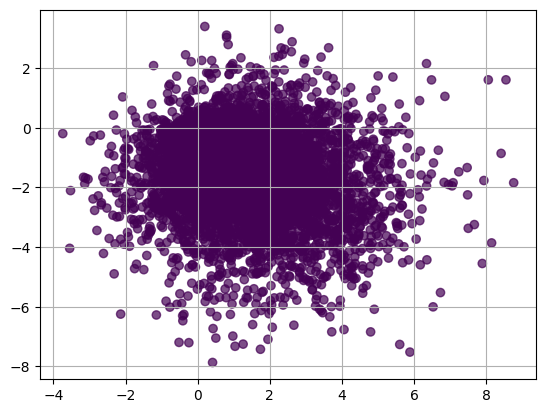

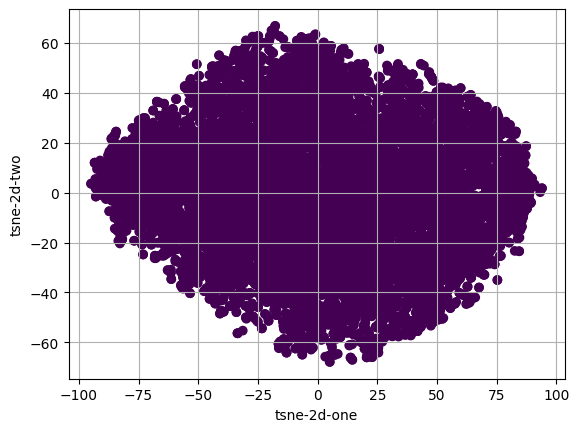

In [3]:

encoded_samples, tsne_results = Reduced_Dimension_Data_Representations(encoder, device, train_dataset, 0)

# Higher dim
plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'],
        c=encoded_samples['label'], alpha=0.7)
plt.grid()
plt.show()


# TSNE of Higher dim
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=encoded_samples['label'])
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.grid()
plt.show()

In [4]:

encoded_samples, tsne_results = Reduced_Dimension_Data_Representations2(encoder, device, train_dataset, 0)

# Higher dim
plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'],
        c=encoded_samples['label'], alpha=0.7)
plt.grid()
plt.show()


# TSNE of Higher dim
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=encoded_samples['label'])
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.grid()
plt.show()

An error occurred: test_dataset must be iterable


TypeError: 'NoneType' object is not subscriptable